In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import *
from qumcmc.quantum_mcmc_routines_qulacs import *     #for Qulacs Simulator backend
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
from typing import Union
from qumcmc.trajectory_processing import *
from qumcmc.training import *

import seaborn as sns

#############
import random
from qulacs import QuantumState
from qulacs_core import DensityMatrix

from qiskit.visualization import plot_histogram

def int_to_str(state_obtained, nspin):
    return f"{state_obtained:0{nspin}b}"

In [2]:
def random_ising_model(n_spins:int, seed:int, print_model:bool= False, ):

    np.random.seed(seed)
    
    ## construct problem Hamiltonian ##
    shape_of_J=(n_spins,n_spins)

    ## defining J matrix (mutual 1-1 interaction)
    # J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
    J =  np.random.uniform(low= -1, high= 1, size= shape_of_J )

    J = 0.5 * (J + J.transpose() )
    J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

    # defining h
    h = np.round(0.4 * np.random.randn(n_spins), decimals=2)
    #h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

    param_model = IsingEnergyFunction(J, h, name= 'param_model')
    
    if print_model : param_model.model_summary()

    return param_model


#### **Training Module**

In [3]:
# from copy import deepcopy
# import pandas as pd

# int_to_binary = lambda state_obtained, n_spins : f"{state_obtained:0{n_spins}b}"
# binary_to_bipolar = lambda string : 2.0 * float(string) - 1.0

# def get_observable_expectation(observable: callable, mcmc_chain: MCMCChain, skip_init:int= 100) :

#     sample_observable = []
#     for s in mcmc_chain.accepted_states :

#         sample_observable.append(observable(s) )
    
#     sample_observable = np.array(sample_observable)
        
#     return sample_observable.mean(dtype= float)#, sample_observable.var(dtype= float)


# def correlation_spins(state: str, indices : Union[tuple, List] ):

#     assert len(indices) <= len(state)
    
    
#     prod = 1.0
#     for j in indices :
#         prod *= binary_to_bipolar(state[j])

#     return prod

# def cd_J(index, data_distribution:DiscreteProbabilityDistribution, mcmc_chain: MCMCChain):

#     assert len(index) == 2
#     observable = lambda s: correlation_spins(s, [index[0], index[1]])
#     r = data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

#     return r

# def cd_h(index:int, data_distribution:DiscreteProbabilityDistribution, mcmc_chain: MCMCChain):

#     assert isinstance(index, int)
#     observable = lambda s: correlation_spins(s, [index])
#     r = data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

#     return r
# # @dataclass
# class cd_training():
#     ''' 
#     model: initial model = (J init, h init) at some temp T
#     beta: 1/Temperature
#     data_dist: empirical data which we want to learn!
    
#     '''

#     def __init__(self, model: IsingEnergyFunction, beta:float ,data_dist: DiscreteProbabilityDistribution) -> None:
#         self.model = deepcopy(model)
#         self.model_beta = beta
#         self.data_distribution = data_dist
#         self.training_history = {}
#         self.list_pair_of_indices=[[i,j] for i in range(1,self.model.num_spins) for j in range(i,self.model.num_spins) if j!=i]
        

#     def cd_J(self, index, mcmc_chain: MCMCChain):

#         assert len(index) == 2
#         observable = lambda s: correlation_spins(s, [index[0], index[1]])
#         r = self.data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

#         return r

#     def cd_h(self, index:int, mcmc_chain: MCMCChain):

#         assert isinstance(index, int)
#         observable = lambda s: correlation_spins(s, [index])
#         r = self.data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

#         return r

#     # @setattr
#     # def data_distribution()
    
#     def _train_on_mcmc_chain(self, lr:float= 0.01, 
#     method = 'quantum-enhanced', 
#     iterations: int = 100, # rename this iterations to something else
#     num_random_Jij: int=10,
#     mcmc_steps:int =1000 ):# we will try to increase mcmc steps. 

#         random.seed(random.random()) ## add seed to random ##TODO
#         if method == 'quantum-enhanced' :
#             self.mcmc_chain = quantum_enhanced_mcmc(
#             n_hops=mcmc_steps,
#             model=self.model,
#             temperature=1/self.model_beta,
#             verbose= False
#             )
#         elif method == 'classical-uniform' : 
#             self.mcmc_chain = classical_mcmc(
#             n_hops=mcmc_steps,
#             model=self.model,
#             temperature=1/self.model_beta,
#             verbose= False
#             )
        
#         ## random update strategy ##
#         ## just realised that even this is not a good thing! 
#         assert iterations<=self.model.num_spins, f"iterations should be <= num_spins (which is= {self.model.num_spins}) "
#         assert num_random_Jij<=len(self.list_pair_of_indices), f"num_random_Jij should be <=len(self.list_pair_of_indices) (which is= {len(self.list_pair_of_indices)})"
        
#         list_random_indices=random.sample(range(0,self.model.num_spins), iterations)
#         #list_pair_of_indices=[[i,j] for i in range(1,self.model.num_spins) for j in range(i,self.model.num_spins) if j!=i]
#         #list_pair_of_different_indices=random.sample(self.list_pair_of_indices,k=num_random_Jij)

#         list_pair_of_different_indices=[[list_random_indices[j],
#                     random.choice(list(range(0,list_random_indices[j]))+list(range(list_random_indices[j]+1,self.model.num_spins)))] 
#                     for j in range(0,iterations)]
        
#         # ## Update J
#         for k in range(len(list_pair_of_different_indices)):
#             indices_J=list_pair_of_different_indices[k]
#             updated_param_j=self.model.J[indices_J[0],indices_J[1]] - lr * self.cd_J(indices_J, self.mcmc_chain)
#             self.model._update_J(updated_param_j, indices_J)

#         for k in range(iterations):
#             #indices_J=list_pair_of_different_indices[k]
#             #updated_param_j = model.J[indices_J[0],indices_J[1]] - lr * self.cd_J(indices_J, self.mcmc_chain)

#             # update h
#             index_h=list_random_indices[k]
#             updated_param_h=self.model.h[index_h] - lr*self.cd_h(index_h,self.mcmc_chain)

#             #self.model._update_J(updated_param_j, indices_J)
#             self.model._update_h(updated_param_h, index_h)
            

#     def train(self, lr:float= 0.01, method = 'quantum-enhanced', 
#     epochs:int = 10, iterations: int = 100, num_random_Jij:int=5,
#     mcmc_steps:int = 500, show_kldiv:bool = True ):

#         ## random update strategy ##
#         kl_div = []
#         iterator = tqdm(range(epochs), desc= 'training epochs')
#         iterator.set_postfix({'method': method})
#         for epoch in iterator:

#             self._train_on_mcmc_chain(lr= lr , 
#             method = method, iterations= iterations, num_random_Jij=num_random_Jij,
#             mcmc_steps= mcmc_steps )

#             if show_kldiv:

                
#                 kl_div.append(kl_divergence(  self.data_distribution,self.mcmc_chain.get_accepted_dict(normalize= True)  ))
#                 iterator.set_postfix( { 'method ': method, 'kl div ' : kl_div[-1] })
        
#         if show_kldiv : self.training_history['kl_div']= kl_div


#### Experiment 1 : Learning Haar-Random Samples

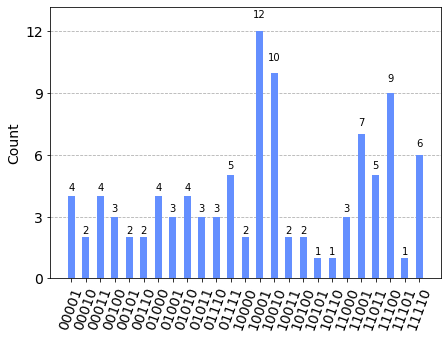

In [5]:
nspin = 5; seed = 32320
st = QuantumState(nspin)
st.set_Haar_random_state(seed)
st_count = Counter([int_to_str(s, nspin) for s in st.sampling(100) ])

DATA = DiscreteProbabilityDistribution( dict(st_count))
plot_histogram(DATA)

            MODEL : param_model
Non-zero Interactions (J) : 10 / 10
Non-zero Bias (h) : 5 / 5
---------------------------------------------
Average Interaction Strength <|J|> :  0.20872
Average Bias Strength <|h|>:  0.372
alpha :  1.539637213375864
---------------------------------------------


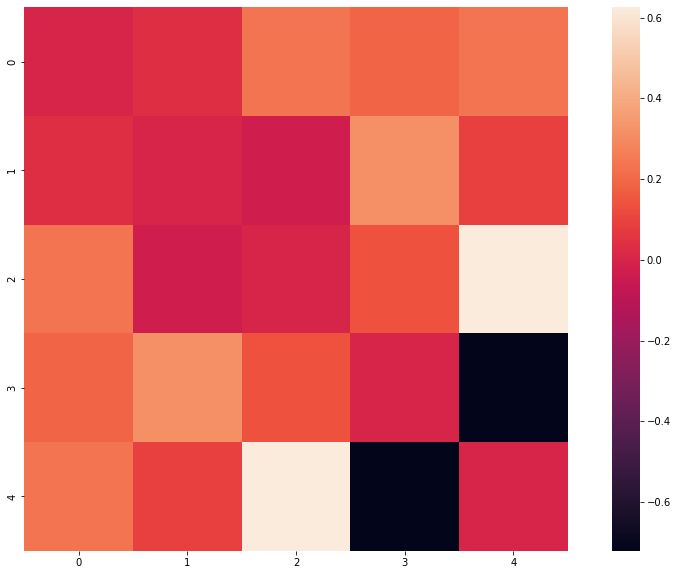

In [6]:
param_model = random_ising_model(nspin, 10232, print_model= True)

     MODEL : param_model |  beta : 0.5
Num Most Probable States : 29
Entropy : None
---------------------------------------------


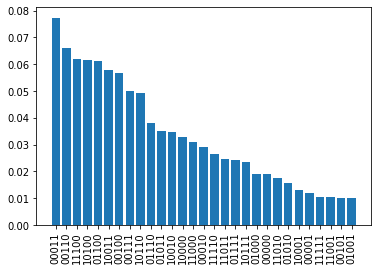

In [10]:
beta_train = 0.5
param_model_exm = Exact_Sampling(param_model, beta= beta_train)
param_model_exm.sampling_summary()

In [11]:
train_cl = cd_training(param_model, beta_train, DATA)

train_cl.train(lr = 0.01 ,method = 'classical-uniform' , epochs= 100, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 1000 , show_kldiv= True)

training epochs: 100%|██████████| 100/100 [00:10<00:00,  9.17it/s, method =classical-uniform, kl div =1.34e+3]


In [12]:
train_q = cd_training(param_model, beta_train, DATA)

train_q.train(lr = 0.01 ,method = 'quantum-enhanced' , epochs= 100, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 1000 , show_kldiv= True)

training epochs: 100%|██████████| 100/100 [17:41<00:00, 10.62s/it, method =quantum-enhanced, kl div =1.35e+3]


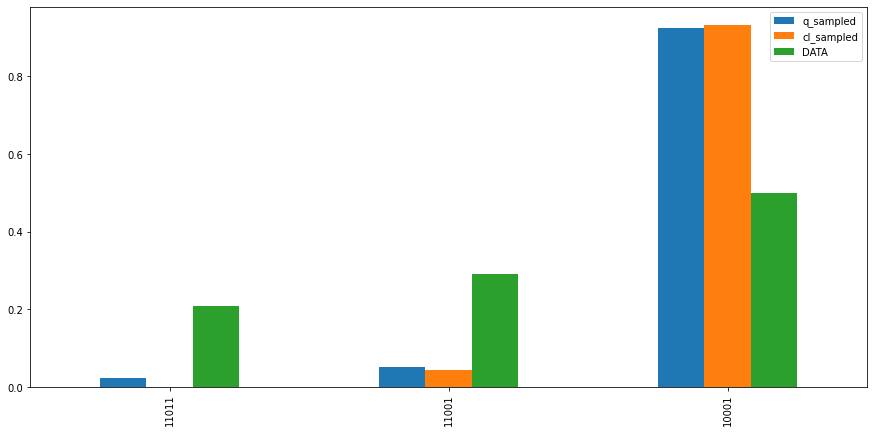

In [13]:
cl_sampled_dist = quantum_enhanced_mcmc(1000, train_cl.model,temperature= 1/beta_train, verbose=False  ).emp_distn_markov_chain_dict(normalize=True)
q_sampled_dist = quantum_enhanced_mcmc(1000, train_q.model,temperature= 1/beta_train, verbose=False  ).emp_distn_markov_chain_dict(normalize=True)
plot_multiple_bargraphs([q_sampled_dist,cl_sampled_dist, DATA], ['q_sampled','cl_sampled', 'DATA'], [False,False, True], plot_first_few= 15)

In [ ]:
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.training_history['kl_div'], label= 'q')
plt.xlabel('iterations'); plt.ylabel('KL div'); plt.title('Training Data')
plt.legend()
plt.show()

            MODEL : param_model
Non-zero Interactions (J) : 10 / 10
Non-zero Bias (h) : 5 / 5
---------------------------------------------
Average Interaction Strength <|J|> :  4.787442629236577
Average Bias Strength <|h|>:  12.903107321060073
alpha :  1.539637213375864
---------------------------------------------


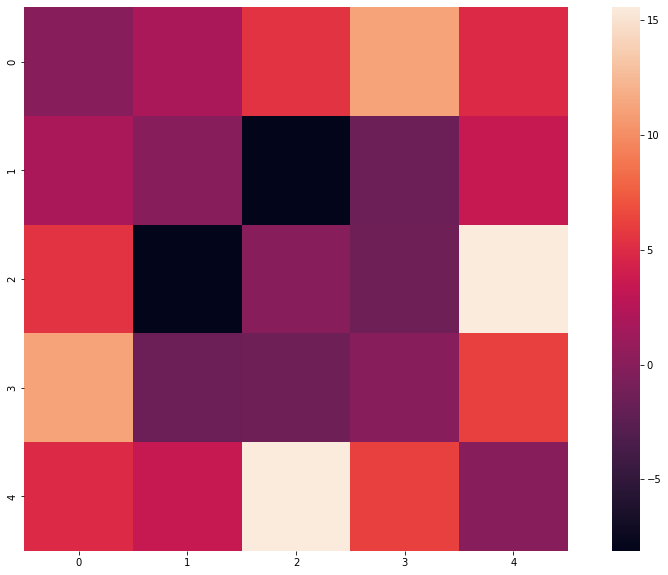

In [14]:
train_q.model.model_summary()

            MODEL : param_model
Non-zero Interactions (J) : 10 / 10
Non-zero Bias (h) : 5 / 5
---------------------------------------------
Average Interaction Strength <|J|> :  4.722185378446898
Average Bias Strength <|h|>:  12.897790349329401
alpha :  1.539637213375864
---------------------------------------------


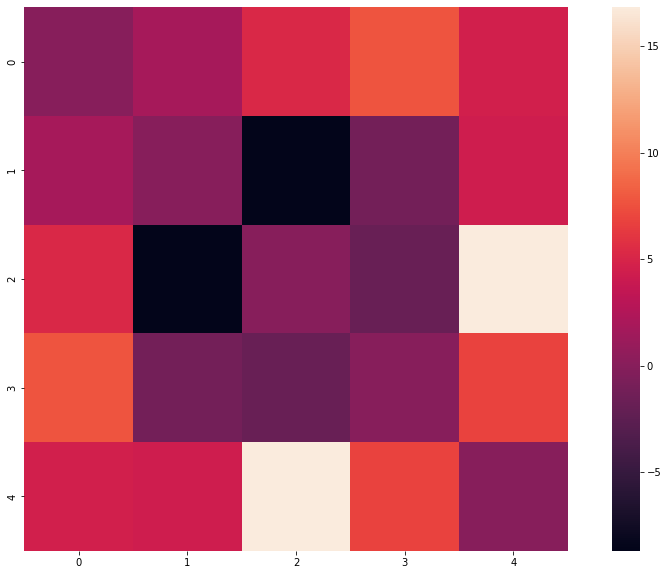

In [15]:
train_cl.model.model_summary()

#### Experiment 2: Sampling from tensor product of single qubit rotations

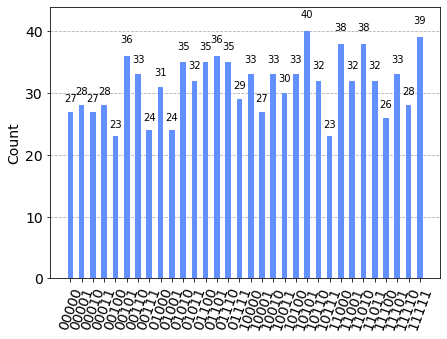

In [16]:
nspin = 5; seed = 1314
np.random.seed(seed)

st = QuantumState(nspin)
rqc = QuantumCircuit(nspin)
for i in range(nspin):
    # rqc.add_RotY_gate(i, np.random.uniform(0,2 * np.pi))  ##random angles
    rqc.add_RotY_gate(i, np.pi/2) ##fixed angles
rqc.update_quantum_state(st)

st_count = Counter([int_to_str(s, nspin) for s in st.sampling(1000) ])
beta_train = 1.0

DATA = DiscreteProbabilityDistribution( dict(st_count))
plot_histogram(DATA)

In [17]:
param_model = random_ising_model(nspin, 5012, print_model= False)

In [18]:
train_cl = cd_training(param_model, beta_train, DATA)

train_cl.train(lr = 0.01 ,method = 'classical-uniform' , epochs= 100, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 1000 , show_kldiv= True)

training epochs: 100%|██████████| 100/100 [00:12<00:00,  8.04it/s, method =classical-uniform, kl div =1.51e+4]


In [20]:
train_q = cd_training(param_model, beta_train, DATA)

train_q.train(lr = 0.01 ,method = 'quantum-enhanced' , epochs= 100, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 1000 , show_kldiv= True)

training epochs:  78%|███████▊  | 78/100 [13:33<03:49, 10.43s/it, method =quantum-enhanced, kl div =1.6e+4] 


ValueError: shapes (5,5) and (6,) not aligned: 5 (dim 1) != 6 (dim 0)

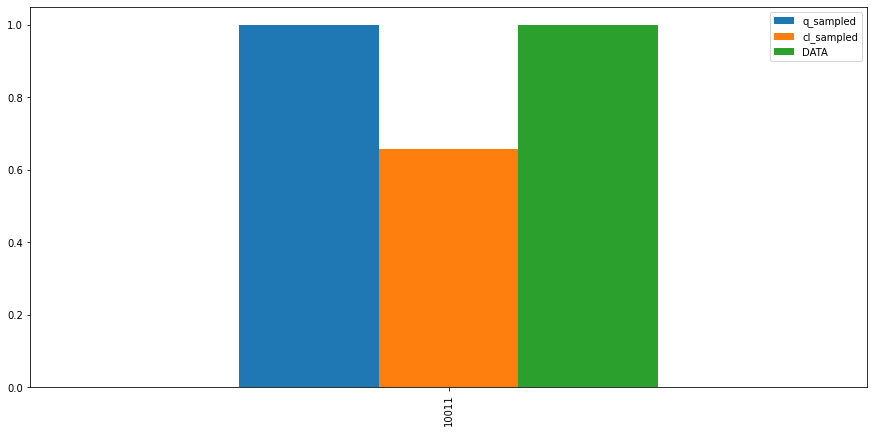

In [ ]:
cl_sampled_dist = quantum_enhanced_mcmc(1000, train_cl.model,temperature= 1/beta_train, verbose=False  ).emp_distn_markov_chain_dict(normalize=True)
q_sampled_dist = quantum_enhanced_mcmc(1000, train_q.model,temperature= 1/beta_train, verbose=False  ).emp_distn_markov_chain_dict(normalize=True)
plot_multiple_bargraphs([q_sampled_dist,cl_sampled_dist, DATA], ['q_sampled','cl_sampled', 'DATA'], [False,False, True], plot_first_few= 15)

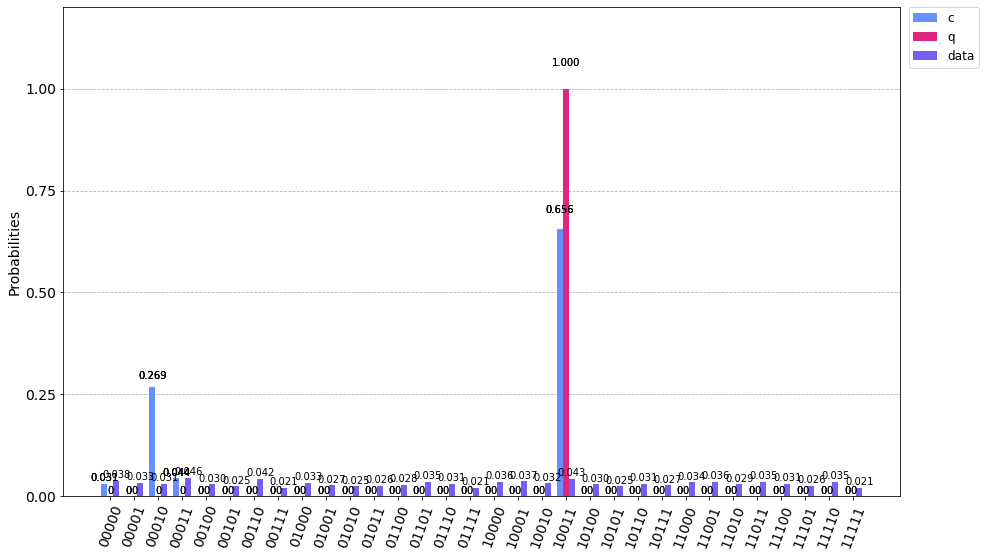

In [ ]:
plot_histogram([dict(cl_sampled_dist),dict(q_sampled_dist) ,DATA], legend= ['c','q','data'], figsize=(15,9))

In [ ]:
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.training_history['kl_div'], label= 'q')
plt.xlabel('iterations'); plt.ylabel('KL div'); plt.title('Training Data')
plt.legend()
plt.show()

            MODEL : param_model
Non-zero Interactions (J) : 10 / 10
Non-zero Bias (h) : 5 / 5
---------------------------------------------
Average Interaction Strength <|J|> :  10.56596440534572
Average Bias Strength <|h|>:  38.35716070219111
alpha :  1.4837141463635448
---------------------------------------------


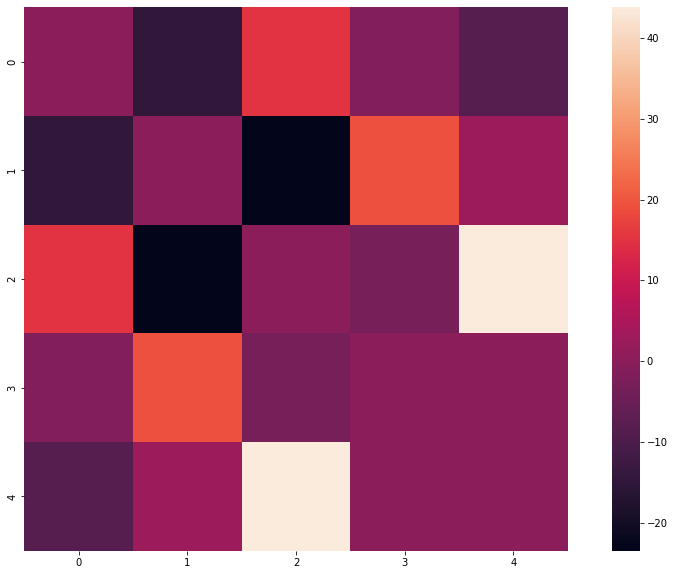

In [94]:
train_cl.model.model_summary()

            MODEL : param_model
Non-zero Interactions (J) : 10 / 10
Non-zero Bias (h) : 5 / 5
---------------------------------------------
Average Interaction Strength <|J|> :  4.874842774589952
Average Bias Strength <|h|>:  19.289635165971088
alpha :  1.4837141463635448
---------------------------------------------


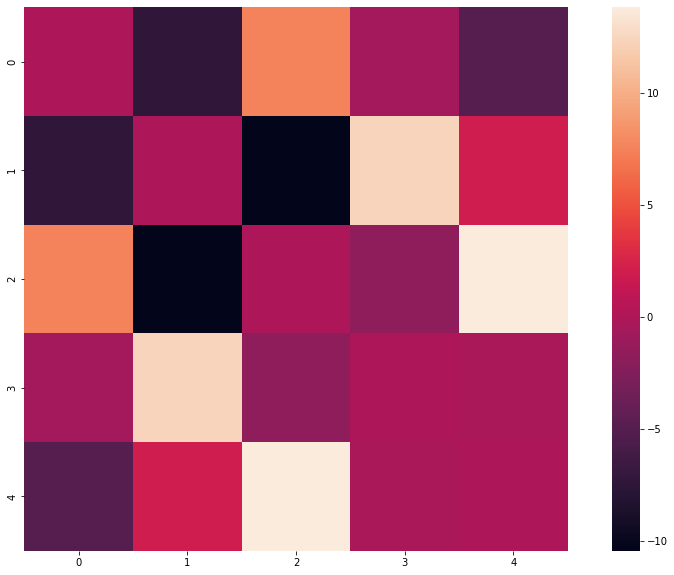

In [95]:
train_q.model.model_summary()

#### Experiment 3: Learning highly entangled states (GHZ/W)

In [31]:
nspin = 5; seed = 131214
### GHZ data
def get_ghz_data(nspin:int):
    return DiscreteProbabilityDistribution({'1'*nspin: 0.5, '0'*nspin: 0.5  })

### W-state data
from itertools import permutations; import functools; import operator
def get_wstate_data(nspin:int):
    elems = list(Counter(permutations('1'+'0'*(nspin-1), nspin)))
    data = dict([( functools.reduce(operator.add, elem), 1.0 / nspin   ) for elem in elems])

    return DiscreteProbabilityDistribution(data)

##### GHZ

In [72]:
DATAghz = get_ghz_data(nspin)

     MODEL : param_model |  beta : 1.9
Num Most Probable States : 9
Entropy : 2.4778850847005924
---------------------------------------------


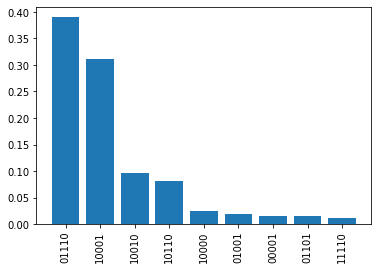

In [73]:
param_model = random_ising_model(nspin, 602872, print_model= False)
beta_train = 1.9
param_model_exm = Exact_Sampling(param_model, beta= beta_train)
param_model_exm.sampling_summary()

In [74]:
train_cl = cd_training(param_model, beta_train, DATAghz)

train_cl.train(lr = 0.03 ,method = 'classical-uniform' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 100 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [00:05<00:00, 39.19it/s, method =classical-uniform, kl div =6.39]  


In [75]:
train_q = cd_training(param_model, beta_train, DATAghz)

train_q.train(lr = 0.01 ,method = 'quantum-enhanced' , epochs= 200, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 100 , show_kldiv= True)

training epochs: 100%|██████████| 200/200 [03:03<00:00,  1.09it/s, method =quantum-enhanced, kl div =1.86]  


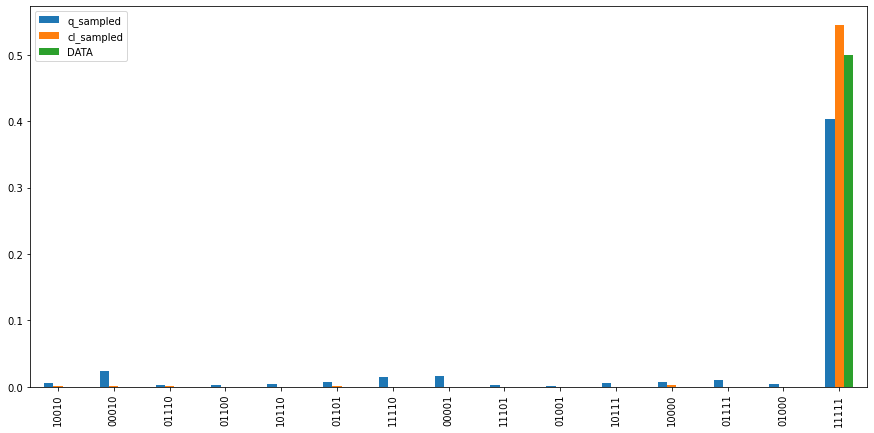

In [76]:
cl_sampled_dist = quantum_enhanced_mcmc(1000, train_cl.model,temperature= 1/beta_train, verbose=False  ).emp_distn_markov_chain_dict(normalize=True)
q_sampled_dist = quantum_enhanced_mcmc(1000, train_q.model,temperature= 1/beta_train, verbose=False  ).emp_distn_markov_chain_dict(normalize=True)
plot_multiple_bargraphs([q_sampled_dist,cl_sampled_dist, DATAghz], ['q_sampled','cl_sampled', 'DATA'], [False,False, True], plot_first_few= 15)

In [ ]:
plot_histogram([dict(cl_sampled_dist),dict(q_sampled_dist) ,DATA], legend= ['c','q','data'], figsize=(15,9))

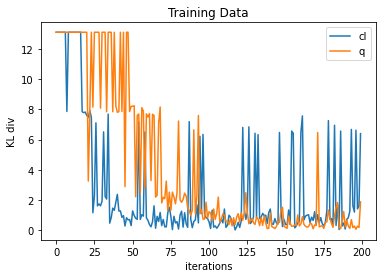

In [77]:
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.training_history['kl_div'], label= 'q')
plt.xlabel('iterations'); plt.ylabel('KL div'); plt.title('Training Data')
plt.legend()
plt.show()

##### W State

In [49]:
DATAw = get_wstate_data(nspin)

In [60]:
train_cl = cd_training(param_model, beta_train, DATAw)

train_cl.train(lr = 0.03 ,method = 'classical-uniform' , epochs= 250, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 100 , show_kldiv= True)

training epochs: 100%|██████████| 250/250 [00:06<00:00, 40.60it/s, method =classical-uniform, kl div =0.459]


In [63]:
# train_q = cd_training(param_model, beta_train, DATAw)

train_q.train(lr = 0.01 ,method = 'quantum-enhanced' , epochs= 250, 
iterations= nspin, num_random_Jij=nspin, mcmc_steps= 100 , show_kldiv= True)

training epochs: 100%|██████████| 250/250 [03:42<00:00,  1.12it/s, method =quantum-enhanced, kl div =0.855]


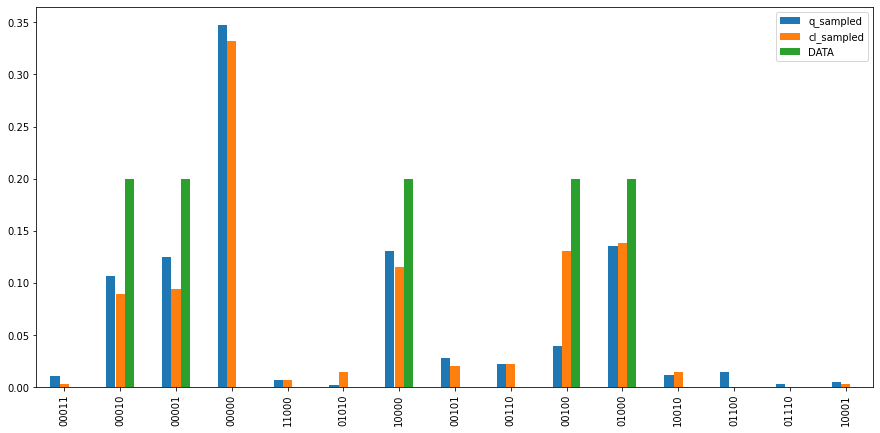

In [64]:
cl_sampled_dist = quantum_enhanced_mcmc(1000, train_cl.model,temperature= 1/beta_train, verbose=False  ).emp_distn_markov_chain_dict(normalize=True)
q_sampled_dist = quantum_enhanced_mcmc(1000, train_q.model,temperature= 1/beta_train, verbose=False  ).emp_distn_markov_chain_dict(normalize=True)
plot_multiple_bargraphs([q_sampled_dist,cl_sampled_dist, DATAw], ['q_sampled','cl_sampled', 'DATA'], [False,False, True], plot_first_few= 15)

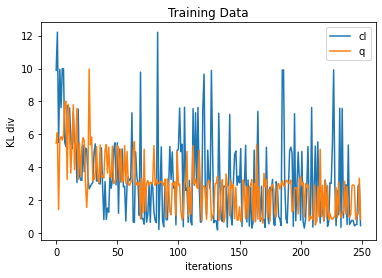

In [70]:
plt.plot(train_cl.training_history['kl_div'], label= 'cl')
plt.plot(train_q.training_history['kl_div'], label= 'q')
plt.xlabel('iterations'); plt.ylabel('KL div'); plt.title('Training Data')
plt.legend()
plt.show()

            MODEL : param_model
Non-zero Interactions (J) : 10 / 10
Non-zero Bias (h) : 5 / 5
---------------------------------------------
Average Interaction Strength <|J|> :  0.14137027835011015
Average Bias Strength <|h|>:  0.7690611911192755
alpha :  1.3674379552513023
---------------------------------------------


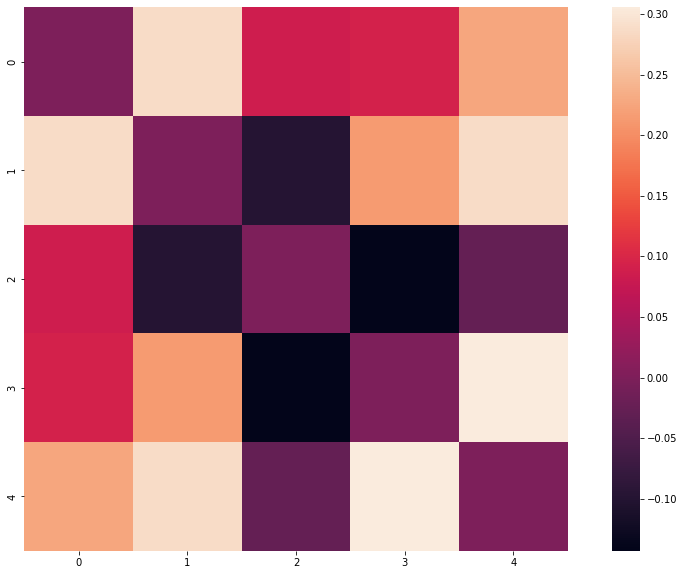

In [65]:
train_q.model.model_summary()

            MODEL : param_model
Non-zero Interactions (J) : 10 / 10
Non-zero Bias (h) : 5 / 5
---------------------------------------------
Average Interaction Strength <|J|> :  0.17366195131185067
Average Bias Strength <|h|>:  1.1362670918818962
alpha :  1.3674379552513023
---------------------------------------------


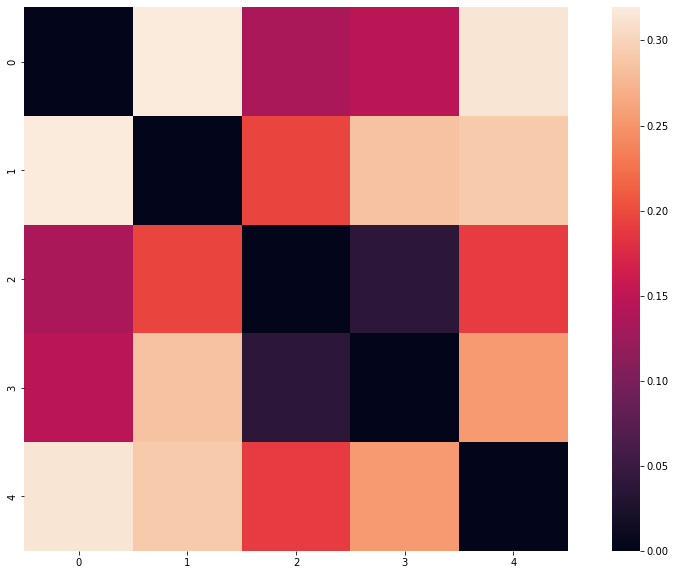

In [66]:
train_cl.model.model_summary()